In [1]:
import pandas as pd
import numpy as np
import spacy
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.naive_bayes import MultinomialNB
from sklearn import svm
from sklearn import model_selection
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import balanced_accuracy_score, recall_score, precision_score, f1_score, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay, matthews_corrcoef, classification_report
from sklearn.metrics import cohen_kappa_score, precision_recall_fscore_support
from sklearn.model_selection import learning_curve
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import RocCurveDisplay

from sklearn.preprocessing import label_binarize
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit

In [2]:
def calc_metrics(classifiers, X, y):
    
    X_train, X_rem, y_train, y_rem = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=True)
    X_valid, X_test, y_valid, y_test = train_test_split(X_rem, y_rem, test_size=0.5, random_state=42, shuffle=True)
    
    results = {}
    for clf in classifiers:
        
        clf_name = type(clf).__name__
        results[clf_name] = {}

        clf.fit(X_train, y_train)
        y_pred_train = clf.predict(X_train)
        y_pred = clf.predict(X_valid)
        
        ConfusionMatrixDisplay.from_predictions(y_valid, y_pred)
        results[clf_name]["accuracy"] = balanced_accuracy_score(y_valid, y_pred)
        
        #fix support being null when using average metric
        all_scores = precision_recall_fscore_support(y_valid, y_pred, pos_label="positive") #macro, micro or weighted?
        results[clf_name]["precision"] = all_scores[0] 
        results[clf_name]["recall"] = all_scores[1] 
        results[clf_name]["f1"] = all_scores[2] 
        results[clf_name]["support"] = all_scores[3] 
        
        #results[clf_name]["roc"] = roc_auc_score(y_test, y_pred)
        results[clf_name]["matthew_coeff"] = matthews_corrcoef(y_valid, y_pred)
        results[clf_name]["cohen_kappa"] = cohen_kappa_score(y_valid, y_pred)
        
    return results

In [3]:
def plot_learning_curve(classifiers, X, y, ylim=None, cv=None, n_jobs=None, 
                        train_sizes=np.linspace(0.1, 1.0, 5),):
    
    size = len(classifiers)
    
    if len(classifiers) > 1:
        _, axes = plt.subplots(1, len(classifiers), figsize=(7.5 * size, 5))
    
    for i in range(0, len(classifiers)):
        
        if ylim is not None:
            axes[i].set_ylim(*ylim)
        axes[i].set_xlabel("Training examples")
        axes[i].set_ylabel("Score")
        
        estimator = classifiers[i]
        clf_name = type(estimator).__name__
        axes[i].set_title(f"Learning Curve ({clf_name})")
        train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)                                                                                                           
        
        train_scores_mean = np.mean(train_scores, axis=1)
        train_scores_std = np.std(train_scores, axis=1)
        test_scores_mean = np.mean(test_scores, axis=1)
        test_scores_std = np.std(test_scores, axis=1)

        # Plot learning curve
        axes[i].grid()
        axes[i].fill_between(
            train_sizes,
            train_scores_mean - train_scores_std,
            train_scores_mean + train_scores_std,
            alpha=0.1,
            color="r",
        )
        axes[i].fill_between(
            train_sizes,
            test_scores_mean - test_scores_std,
            test_scores_mean + test_scores_std,
            alpha=0.1,
            color="g",
        )
        axes[i].plot(
            train_sizes, train_scores_mean, "o-", color="r", label="Training score"
        )
        axes[i].plot(
            train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score"
        )
        axes[i].legend(loc="best")
    return plt

In [4]:
def get_binary_df():
    return pd.read_csv("tweet_emotions_binary_cleaned.csv")

def get_ternary_df():
    return pd.read_csv("tweet_emotions_three_classes_cleaned.csv")

def get_complete_df():
    return pd.read_csv("tweet_emotions_cleaned.csv")

In [5]:
def get_spacy_embedding(df, X_train, X_test):
    X_train = [nlp(text).vector for text in X_train]
    X_test = [nlp(text).vector for text in X_test]
    
    return X_train, X_test

In [6]:
def train_models(df, vectorizer, text="text", labels="emotion"):
    classifiers = [svm.LinearSVC(), RandomForestClassifier()] #DecisionTreeClassifier()]# # MLPClassifier()]

    #look into learning curves (do we have enough samples?) / validation curves (is the model under/overfitting?)
    
    X = vect.transform(df[text])
    y = df[labels]

    print("Amount of features: ", len(vect.get_feature_names_out()))
    print("Features: ", vect.get_feature_names_out())

    cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
    plot_learning_curve(classifiers, X, y, ylim=(0.5, 1.01), cv=cv, n_jobs=4)
    
    results = calc_metrics(classifiers, X, y)
    
    df_results = pd.DataFrame(results)
    return df_results

    plt.show()

In [7]:
def remove_empty_rows(df, text="cleaned_content", labels="new_sentiment"):
    df[text].replace("", np.nan, inplace=True)
    df[labels].replace("", np.nan, inplace=True)
    df.dropna(subset=[text], inplace=True)
    df.dropna(subset=[labels], inplace=True)
    return df

       Unnamed: 0  index    tweet_id sentiment  \
24263       24306  24306  1752532825  negative   
28984       29033  29033  1753884644  positive   
11046       11064  11064  1964575179  negative   
191           191    191  1957028895  negative   
17614       17639  17639  1694664836  negative   
23438       23478  23478  1752157660  positive   
22001       22037  22037  1751430428  positive   
25892       25938  25938  1753097023  positive   
14296       14317  14317  1966082400  negative   
20705       20738  20738  1696086496  negative   

                                                 content  \
24263  @lightgood thank you  You too! I hope this tur...   
28984  @nataliefisher I like the idea of eliminating ...   
11046  @Ponyless soz i neva saw this message till now...   
191             I haven't seen Muffin in two whole days!   
17614  @karuski try again, minna  i edited quickly, s...   
23438  Downtown drinking celebrating the cavs victory!!!   
22001                        

C:\Users\Paul\anaconda3\envs\intro2nlp\lib\site-packages\sklearn\metrics\_classification.py:1370: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got None). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
C:\Users\Paul\anaconda3\envs\intro2nlp\lib\site-packages\sklearn\metrics\_classification.py:1370: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got None). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(


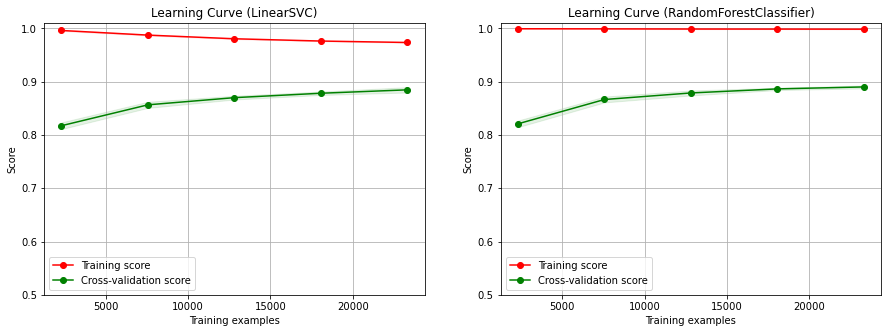

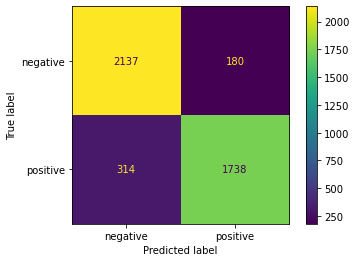

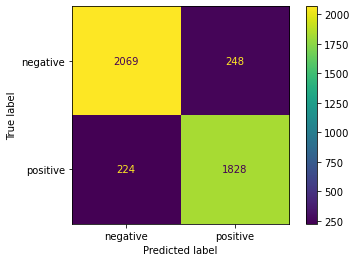

In [12]:
df = get_binary_df()
df = remove_empty_rows(df, "cleaned_content", "new_sentiment")
vect = TfidfVectorizer()
vect.fit(df["cleaned_content"])

print(df.sample(10))
df_results = train_models(df, vect, text="cleaned_content", labels="new_sentiment")

In [11]:
df_results.head(10)

,LinearSVC,RandomForestClassifier
accuracy,0.884646,0.892577
precision,"[0.8718890248878008, 0.9061522419186653]","[0.9027898866608544, 0.8814457831325301]"
recall,"[0.9223133362106172, 0.8469785575048733]","[0.8938282261545102, 0.8913255360623782]"
f1,"[0.8963926174496644, 0.8755667506297229]","[0.8982867057037518, 0.8863581293918099]"
support,"[2317, 2052]","[2317, 2052]"
matthew_coeff,0.773654,0.784695
cohen_kappa,0.772175,0.784651
